Session 2 - Topic 2
===================
Frame Objects and Function Calling Internals - DEEP DIVE



# =====================================
# 1. Why Frame Objects Exist
# =====================================


- A frame object (PyFrameObject) represents an *execution context*.
- Every active function call has its own frame.
- Frames maintain:
    - Local variables
    - Global variables
    - Builtins
    - Instruction pointer (bytecode offset)
    - Call back-link to previous frame
- Essential for:
    - Recursive calls
    - Debugging
    - Exception tracing (tracebacks follow frame chain)


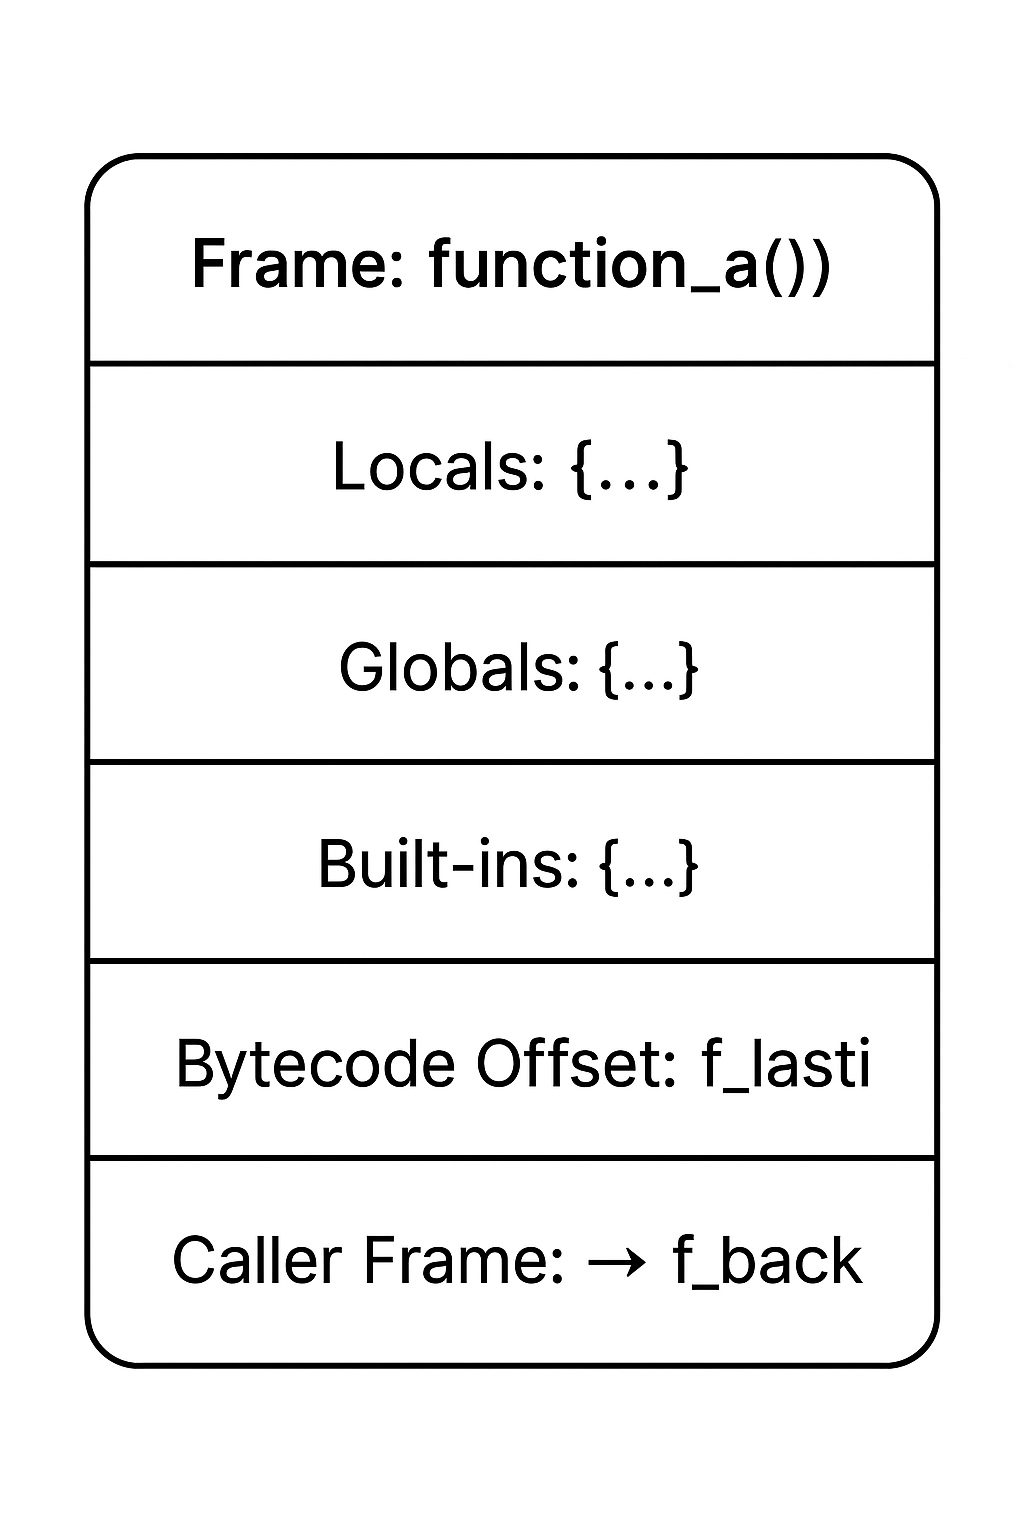


# =====================================
# 2. Inspecting Live Frames with inspect Module
# =====================================


Python’s inspect module gives a pure Python API to peek into frame internals.


In [1]:

import inspect

def first():
    second()

def second():
    third()

def third():
    frame = inspect.currentframe()
    print("\nCurrent Frame:")
    print("Function name:", frame.f_code.co_name)
    print("Locals:", frame.f_locals)
    print("Bytecode offset (f_lasti):", frame.f_lasti)

    back = frame.f_back
    print("\nCaller Frame:")
    print("Function name:", back.f_code.co_name)

    back2 = back.f_back
    print("\nGrandcaller Frame:")
    print("Function name:", back2.f_code.co_name)

first()

# =====================================
# 3. Understanding Frame Chains
# =====================================



Current Frame:
Function name: third
Locals: {'frame': <frame at 0x7b908ef96f80, file '<ipython-input-1-9e8082db5cb4>', line 13, code third>}
Bytecode offset (f_lasti): 192

Caller Frame:
Function name: second

Grandcaller Frame:
Function name: first


Each call creates a new frame.
- f_back links to the caller.
- Walking f_back repeatedly gives entire call stack.
- Frame chain ends at top-level interpreter frame (e.g., __main__).


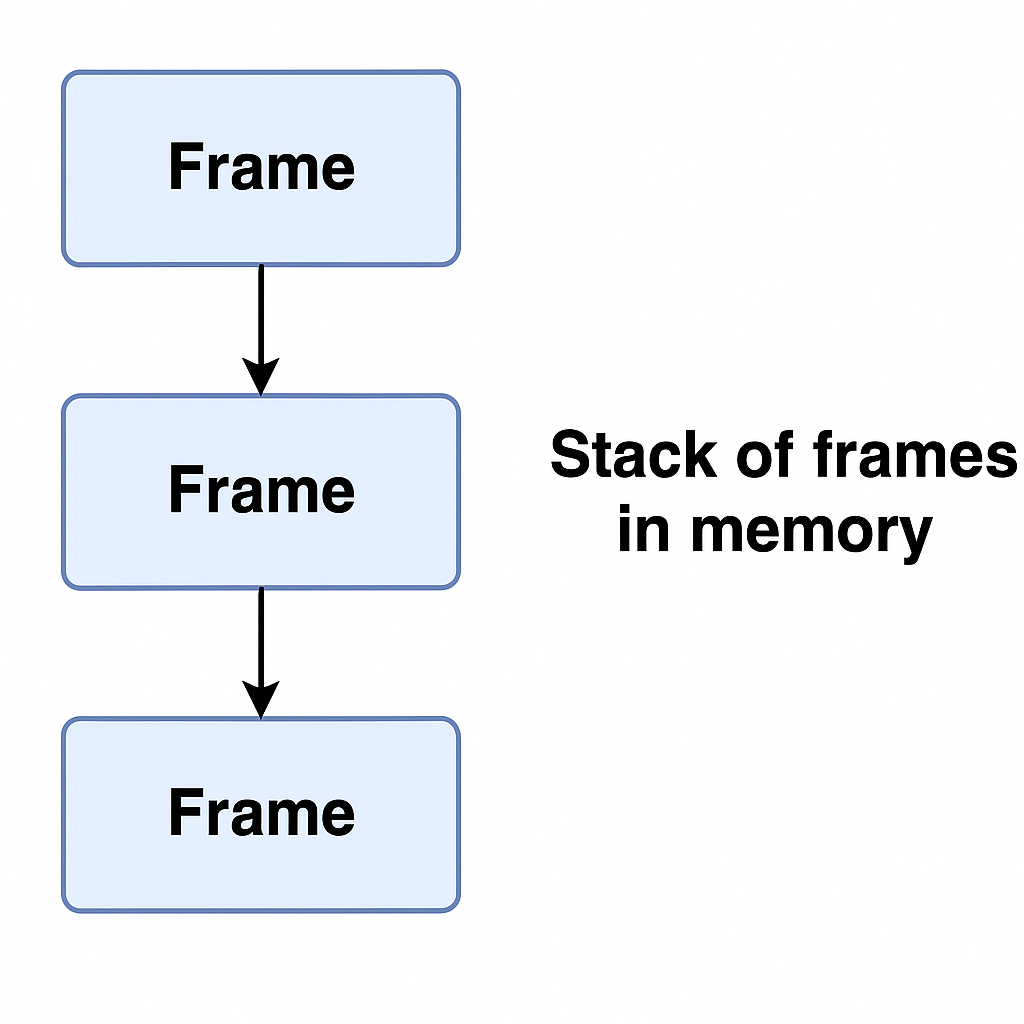

In [2]:

def walk_frame_chain():
    frame = inspect.currentframe()
    depth = 0
    while frame:
        print(f"Depth {depth}: Function {frame.f_code.co_name}")
        frame = frame.f_back
        depth += 1

print("\nWalking current frame chain:")
walk_frame_chain()

# =====================================
# 4. How Function Calls Work Internally
# =====================================



Walking current frame chain:
Depth 0: Function walk_frame_chain
Depth 1: Function <cell line: 0>
Depth 2: Function run_code
Depth 3: Function run_ast_nodes
Depth 4: Function run_cell_async
Depth 5: Function _pseudo_sync_runner
Depth 6: Function _run_cell
Depth 7: Function run_cell
Depth 8: Function run_cell
Depth 9: Function do_execute
Depth 10: Function execute_request
Depth 11: Function dispatch_shell
Depth 12: Function process_one
Depth 13: Function dispatch_queue
Depth 14: Function _run
Depth 15: Function _run_once
Depth 16: Function run_forever
Depth 17: Function start
Depth 18: Function start
Depth 19: Function launch_instance
Depth 20: Function <module>
Depth 21: Function _run_code
Depth 22: Function _run_module_as_main


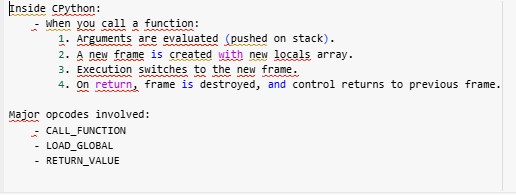

In [3]:

import dis

def add(x, y):
    return x + y

print("\nDisassembly of simple add function:")
dis.dis(add)

# Look for LOAD_FAST, BINARY_ADD, RETURN_VALUE opcodes.

# =====================================
# 5. Fast Locals Optimization
# =====================================



Disassembly of simple add function:
  3           0 RESUME                   0

  4           2 LOAD_FAST                0 (x)
              4 LOAD_FAST                1 (y)
              6 BINARY_OP                0 (+)
             10 RETURN_VALUE


Optimization:
- Instead of using a dictionary for locals, Python uses a *fixed array* internally.
- LOAD_FAST and STORE_FAST opcodes directly index into this array.
- Result: variable access becomes O(1) indexed lookup instead of hash table search.

Evidence:
- Functions without dynamic locals are much faster than exec() or eval() scopes.


In [ ]:

def fast_example(a, b):
    return a * b

print("\nDisassembly of fast locals example:")
dis.dis(fast_example)

# Look for LOAD_FAST / STORE_FAST — direct slot access.

# =====================================
# 6. Inline Caches and Specialization
# =====================================


Python 3.11+ introduced Adaptive Specialization (PEP 659):
- Opcodes mutate at runtime after a few executions to a specialized version.
- Reduces attribute lookup cost, call overhead.

Example:
- LOAD_ATTR --> LOAD_ATTR_ADAPTIVE --> LOAD_ATTR_SLOT / LOAD_ATTR_INSTANCE_VALUE

You can observe specialization stats via sys._get_specialization_stats().


In [1]:
#
import sys

def attr_demo():
    class Obj:
        def __init__(self):
            self.val = 10
    o = Obj()
    return o.val

attr_demo()
print("\nSpecialization stats (may require Python 3.11+):")
try:
    print(sys._get_specialization_stats())
except AttributeError:
    print("Specialization stats not available (needs Python 3.11+)")

# =====================================
# 7. When Frame Knowledge Helps or Hurts
# =====================================



Specialization stats (may require Python 3.11+):
Specialization stats not available (needs Python 3.11+)


In [3]:
import time
import inspect

def slow_function():
    start = time.time()

    # Faster and more predictable inspection
    caller = inspect.currentframe().f_back
    if caller.f_code.co_name == 'slow_caller':
        time.sleep(0.05)  # simulate slowness
    else:
        time.sleep(0.001)  # fast path

    elapsed = time.time() - start
    if elapsed > 0.01:
        print(f"[Slow call] from {caller.f_code.co_name} → {elapsed:.4f} sec")

def slow_caller():
    for _ in range(3):
        slow_function()

def fast_caller():
    for _ in range(3):
        slow_function()

slow_caller()
fast_caller()


[Slow call] from slow_caller → 0.0502 sec
[Slow call] from slow_caller → 0.0501 sec
[Slow call] from slow_caller → 0.0501 sec


Helps:
- Debugging deeply recursive calls.
- Custom tracers, profilers, debuggers (e.g., coverage tools).
- Detecting memory leaks (lingering frame references).

Hurts:
- Over-optimizing trivial code paths.
- Misusing inspect to peek into frames instead of clean design.
- Keeping frame references alive → memory leaks (common GC bug).



# ===========================
# END OF TOPIC 2
# ===========================

